# Example of the usage of the Weak label classifier

We first need to load:

1. **Standard Python libraries** for data handling and reproducibility.  
2. **PyTorch** (and its submodules) for model definition, training, and data loading.  
3. **Custom modules** from this project:
   - **`train_test_loop`**: provides the `train_and_evaluate` function to run training and evaluation loops.  
   - **`losses`**: contains various weak‐label‐aware loss functions like `FwdBwdLoss`.  
   - **`weakener`**: implements the `Weakener` class for generating noisy/weak labels.  
   - **`model`**: defines model architectures .
   - **`dataset`**: provides `Data_handling` (and other dataset classes) for loading and splitting data.  

In [1]:
# Standard libraries
# import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch core
import torch
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

# Custom project modules
from utils.train_test_loop import train_and_evaluate
# from utils.losses import FwdLoss, EMLoss, FwdBwdLoss, MarginalChainLoss
from utils.losses1 import MarginalChainProperLoss, ForwardProperLoss, ForwardBackwardProperLoss, scoring_matrix
from utils.losses1 import PiCOLoss, IRLoss, UpperBoundWeakProperLoss
# from utils.dataset_visualization import visualize_dataset
from src.weakener import Weakener
from src.model import MLP
from src.dataset import Data_handling

# Set random seeds for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading and Visualizing Iris

1. **Instantiate** our `Data_handling` class to load the Iris dataset from OpenML (ID 61) using an 80/20 train/test split.  
2. **Retrieve** the raw arrays of features and labels via `get_data()`.  
3. **Combine** the train and test portions back into a single DataFrame 
4. **Visualize** 

In [2]:
# dataset_name = 'Cifar10'
dataset_name = 'mnist'
Data = Data_handling(
    dataset=dataset_name,
    train_size=0.8,
    test_size=0.2,
    batch_size=64,
    shuffling=False,
    splitting_seed=42,
)

In [3]:
Data.train_dataset.data # This is Train_X
Data.train_dataset.targets # This is Train_y

print(f"Number of classes: {Data.num_classes}")
print(f"Array of targets: \n {Data.test_dataset.targets}")
df = pd.DataFrame(
    Data.train_dataset.data.numpy(),
    # columns=[f'feature_{i}' 
    columns=[f'x_{i}' 
             for i in range(Data.train_dataset.data.shape[1])])

# Add target column
df['target'] = [i for i in Data.train_dataset.targets.numpy()]

# Print 3 rows
print(df.head(3))

Number of classes: 10
Array of targets: 
 tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
   x_0  x_1  x_2  x_3  x_4  x_5  x_6  x_7  x_8  x_9  ...  x_775  x_776  x_777  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   

   x_778  x_779  x_780  x_781  x_782  x_783  \
0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0    0.0    0.0    0.0   

                                              target  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
1  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 1

Next, we’ll simulate a **partial‐label learning** or **noisy-label** setting by corrupting each true label with **M**:

1. **Instantiate** a `Weakener` with the number of true classes.  
2. **Build** a mixing matrix via `generate_M(model_class='pll', corr_p=…)` 
3. **Generate** weak labels with `generate_weak`, which returns:
   - `z`: the integer index of the weak‐label   
   - `w`: a binary matrix of shape `(n_samples, n_classes)` indicating the candidate labels  
4. **Insert** the partial labels into our Data using `include_weak(w)`.  

In [4]:
# Generate transition matrix M
corr_p = 0.2
weakener = Weakener(true_classes=Data.num_classes)

weakener.generate_M(model_class='pll', corr_p=0.2) # For partial label learning (PLL)
#weakener.generate_M(model_class='unif_noise', corr_p=0.5) # For noisy labels

print(f"Generated M matrix:\n"
      f"{np.array2string(weakener.M, precision=4, suppress_small=True)}")

# Generate weak labels z
true_onehot = Data.train_dataset.targets  # shape: (n_samples, n_classes)
z = weakener.generate_weak(
    true_onehot, compute_w=True, compute_Y=True, compute_Y_opt=False,
    compute_Y_conv=False, compute_Y_opt_conv=False)
#想跑哪种就把对应开关打开，就是改成True，其他的改成False

print(f"Generated weak labels z:\n{z}")

# Compute virtual labels
print("Computing virtual labels...")
# Since z[i] is an integer, row i must contain the z[i]-th row of weakener.Z
virtual_labels = weakener.Z[z]

# Add weak and virtual labels to the dataset
Data.include_weak(z)
Data.include_virtual(virtual_labels, initial_weight=1/Data.num_classes)

# Get dataloaders with weak labels and indices
train_loader, test_loader = Data.get_dataloader(
    weak_labels='all', get_index=True)

Generated M matrix:
[[0.     0.     0.     ... 0.     0.     0.1342]
 [0.     0.     0.     ... 0.     0.1342 0.    ]
 [0.     0.     0.     ... 0.     0.0336 0.0336]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]]
Generated weak labels z:
tensor([144, 648, 176,  ...,  17,  23,  18], dtype=torch.int32)
Computing virtual labels...


In [5]:
batch = next(iter(train_loader))
xb, wb, vb, cb, yb, ib = batch
print(f"Inputs batch: shape {xb.shape}")
print(f"Weak (partial) labels: shape {wb.shape}, first row: {wb[0]}")
print(f"Virtual labels: shape {vb.shape}, first row: {vb[0]}")
print(f"Weights: shape {cb.shape}, first row: {cb[0]}")
print(f"True one-hot labels shape: {yb.shape}, first row: {yb[0]}")
print(f"Indices batch: shape {ib.shape}, first row: {ib[0]}")

Inputs batch: shape torch.Size([64, 784])
Weak (partial) labels: shape torch.Size([64]), first row: 144
Virtual labels: shape torch.Size([64, 10]), first row: tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1])
Weights: shape torch.Size([64, 10]), first row: tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
True one-hot labels shape: torch.Size([64, 10]), first row: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Indices batch: shape torch.Size([64]), first row: 0


In [6]:
weak_df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'x_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in weakener.w.numpy()]




1. **Instantiate** the model (e.g. `MLP`) with its input/output dimensions.   
2. **Choose** the optimizer and set hyperparameters.  
3. **Define** the loss function.

We also could do a learning rate scheduler (e.g. `StepLR`) to decrease the LR over time. 

## Training the MLP (using `train_test_loop.py`)

1. **Set** training hyperparameters  
2. **Call** `train_and_evaluate(model, train_loader, test_loader, optimizer, pll_loss, num_epochs, corr_p)`
3. **Plot** results

In [7]:
# ##########################
# Define model and optimizer
def get_model(Data, opt_alg='adam', lr=1e-6, momentum=0.9):
    """ Define model and optimizer
    Parameters
        Data: dataset object with num_classes and num_features attributes
    Returns
        model: the neural network model
        optimizer: the optimizer
    """

    model = MLP(
        input_size=Data.num_features,
        hidden_sizes=[],
        output_size=Data.num_classes,
        dropout_p=0,
        bn=False,
        activation='relu')

    if opt_alg == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt_alg == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    else:
        raise ValueError(f"Unsupported optimizer: {opt_alg}") 

    return model, optimizer

# ########################
# Visualization of results
def plot_results(results_df):
    """ Plot training results
    Parameters
        results_df: DataFrame with training results
    """

    # Set up a wide figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Loss curves
    ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()
    ax1.grid(True)

    # Accuracy curves
    ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
    ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

Now we define a method with the steps of each simulation to test a learning algorithm

In [8]:
def run_simulation(Data, loss, num_epochs=10, optimizer_name='adam', 
                   loss_code=None, pseudolabel_model=None, lr=1e-6, corr_p=0.2,
                   phi=0.8):
    """Run a training simulation with the specified parameters.

    Parameters
    ----------
    Data : dataset object
        The dataset object containing training and test data.
    loss : loss function object
        The loss function to use for training.
    num_epochs : int, optional
        The number of training epochs (default is 10).
    optimizer_name : str, optional
        The name of the optimizer to use (default is 'adam').
    loss_code : str, optional
        A code representing the loss function (for metadata) (default is None).
    pseudolabel_model : str, optional
        A string indicating the pseudolabel model used (for metadata)
        (default is None).
    lr : float, optional
        The learning rate for the optimizer (default is 1e-6).
    corr_p : float, optional
        The corruption probability used in the weak label generation 
        (for metadata) (default is 0.2).
    phi : float, optional
        The phi parameter for the training loop (default is 0.8).
    """

    # 1. Get model and optimizer
    model, optimizer = get_model(Data, opt_alg=optimizer_name, lr=lr)

    # 2. Run the training + evaluation loop
    model, results_df = train_and_evaluate(
        model, train_loader, test_loader, optimizer, loss, num_epochs,
        phi=phi, pseudolabel_model=pseudolabel_model)

    # 3. Save simultation attributes in a metadata dictionary
    metadata = {'pseudo_label_model': pseudolabel_model, 'loss_name': loss_code, 
                'corr_p': corr_p, 'optimizer': type(optimizer).__name__,
                'initial_lr': optimizer.param_groups[0]['lr'], 'phi': phi}
    print(pd.DataFrame([metadata]).T)

    # 4. View the epoch‐by‐epoch results
    plot_results(results_df)

    return model, optimizer, metadata, results_df

In [9]:
# #####################################
# Common parameters for all simulations

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training parameters
num_epochs = 20
optimizer_name = 'adam'
lr = 1e-6

Using device: cuda


## Running experiments  

Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/20: Train Loss: 0.2321, Train Acc: 0.9095, Test Acc: 0.9160, Train Detached Loss: 0.3175, Test Detached Loss: 0.3061, Learning Rate: 0.000001, Epoch Time: 3.24 seconds
Epoch 20/20: Train Loss: 0.1969, Train Acc: 0.9216, Test Acc: 0.9240, Train Detached Loss: 0.2888, Test Detached Loss: 0.2861, Learning Rate: 0.000001, Epoch Time: 3.02 seconds
                                0
pseudo_label_model           PiCO
loss_name           cross_entropy
corr_p                        0.2
optimizer                    Adam
initial_lr               0.000001
phi                           0.8


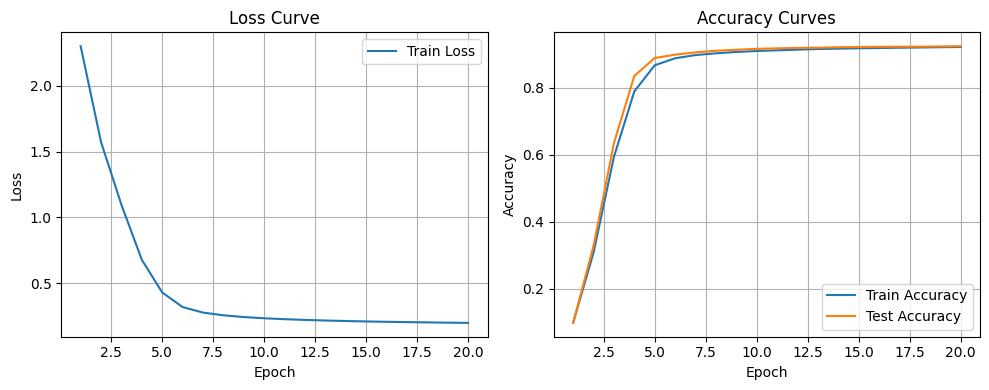

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,PiCO,2.302585,0.098717,0.0980,2.302585,2.302585,0.000001,3.162175
1,2,PiCO,1.572708,0.307800,0.3278,1.785806,1.784778,0.000001,2.992347
2,3,PiCO,1.095205,0.593417,0.6347,1.034777,1.021934,0.000001,2.962359
3,4,PiCO,0.676970,0.789117,0.8354,0.601625,0.582615,0.000001,3.003787
4,5,PiCO,0.428231,0.866950,0.8886,0.429563,0.410629,0.000001,2.860227
5,6,PiCO,0.317316,0.887917,0.8987,0.375944,0.359601,0.000001,2.964051
6,7,PiCO,0.275443,0.897433,0.9055,0.351565,0.336810,0.000001,3.491482
7,8,PiCO,0.254592,0.902667,0.9103,0.335753,0.322165,0.000001,2.980152
8,9,PiCO,0.241417,0.906717,0.9133,0.325270,0.312760,0.000001,2.924445
9,10,PiCO,0.232128,0.909450,0.9160,0.317527,0.306128,0.000001,3.244560


In [10]:
# #################
# Testing PiCO Loss

loss_code = "cross_entropy"
loss = PiCOLoss(loss_code=loss_code)
pseudolabel_model = 'PiCO'
phi = 0.8

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


In [11]:
# #################
# Backward Proper Loss

loss_code = "cross_entropy"

# 选择一个 reconstruction matrix（d x C）
# B = weakener.Y.T          # inverse matrix
# B = weakener.Y_conv.T     # inverse convex matrix
# B = weakener.Y_opt.T      # inverse optimized matrix
# B = weakener.Y_opt_conv.T # inverse optimized convex matrix
B = weakener.Y.T

loss = ForwardBackwardProperLoss(B, np.eye(Data.num_classes), loss_code=loss_code)
pseudolabel_model = 'BWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name,
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=0.8)

results_df.head(num_epochs)

Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.


KeyboardInterrupt: 

In [ ]:
# #################
# Testing IR Loss

loss_code = "cross_entropy"
loss = IRLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'IR'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p)

results_df.head(num_epochs)


In [ ]:
# #################
# Marginal Chain

loss_code = "cross_entropy"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


In [ ]:
# #################
# Forward Proper Loss

loss_code = "cross_entropy"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
# ############
# Majorization-Minimization (Uppder bound)

loss_code = "cross_entropy"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
# #################
# Backward Proper Loss

loss_code = "ps_2"

# 选择一个 reconstruction matrix（d x C）
# B = weakener.Y.T          # inverse matrix
# B = weakener.Y_conv.T     # inverse convex matrix
# B = weakener.Y_opt.T      # inverse optimized matrix
# B = weakener.Y_opt_conv.T # inverse optimized convex matrix
B = weakener.Y.T

loss = ForwardBackwardProperLoss(B, np.eye(Data.num_classes), loss_code=loss_code)
pseudolabel_model = 'BWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name,
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
# #################
# Testing IR Loss

loss_code = "ps_2"
loss = IRLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'IR'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p)

results_df.head(num_epochs)


In [ ]:
# #################
# Testing PiCO Loss

loss_code = "ps_2"
loss = PiCOLoss(loss_code=loss_code)
pseudolabel_model = 'PiCO'
phi = 0.8

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


In [ ]:
# #################
# Marginal Chain

loss_code = "ps_2"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
loss_code = "ps_2"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
loss_code = "ps_2"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'


model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
# #################
# Backward Proper Loss

loss_code = "spherical"

# 选择一个 reconstruction matrix（d x C）
# B = weakener.Y.T          # inverse matrix
# B = weakener.Y_conv.T     # inverse convex matrix
# B = weakener.Y_opt.T      # inverse optimized matrix
# B = weakener.Y_opt_conv.T # inverse optimized convex matrix
B = weakener.Y.T

loss = ForwardBackwardProperLoss(B, np.eye(Data.num_classes), loss_code=loss_code)
pseudolabel_model = 'BWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name,
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
# #################
# Testing IR Loss

loss_code = "spherical"
loss = IRLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'IR'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p)

results_df.head(num_epochs)


In [ ]:
# #################
# Testing PiCO Loss

loss_code = "spherical"
loss = PiCOLoss(loss_code=loss_code)
pseudolabel_model = 'PiCO'
phi = 0.8

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


In [ ]:
# #################
# Marginal Chain

loss_code = "spherical"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
loss_code = "spherical"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
loss_code = "spherical"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'


model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
# #################
# Backward Proper Loss

loss_code = "brier"

# 选择一个 reconstruction matrix（d x C）
# B = weakener.Y.T          # inverse matrix
# B = weakener.Y_conv.T     # inverse convex matrix
# B = weakener.Y_opt.T      # inverse optimized matrix
# B = weakener.Y_opt_conv.T # inverse optimized convex matrix
B = weakener.Y.T

loss = ForwardBackwardProperLoss(B, np.eye(Data.num_classes), loss_code=loss_code)
pseudolabel_model = 'BWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name,
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
# #################
# Testing IR Loss

loss_code = "brier"
loss = IRLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'IR'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p)

results_df.head(num_epochs)


In [ ]:
# #################
# Testing PiCO Loss

loss_code = "brier"
loss = PiCOLoss(loss_code=loss_code)
pseudolabel_model = 'PiCO'
phi = 0.8

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


In [ ]:
# ##############
# Marginal Chain

loss_code = "brier"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
loss_code = "brier"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

In [ ]:
loss_code = "brier"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'


model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
# #################
# Backward Proper Loss

loss_code = "tsallis_0.2"

# 选择一个 reconstruction matrix（d x C）
# B = weakener.Y.T          # inverse matrix
# B = weakener.Y_conv.T     # inverse convex matrix
# B = weakener.Y_opt.T      # inverse optimized matrix
# B = weakener.Y_opt_conv.T # inverse optimized convex matrix
B = weakener.Y.T

loss = ForwardBackwardProperLoss(B, np.eye(Data.num_classes), loss_code=loss_code)
pseudolabel_model = 'BWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name,
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
# #################
# Testing IR Loss

loss_code = "tsallis_0.2"
loss = IRLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'IR'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p)

results_df.head(num_epochs)


In [ ]:
# #################
# Testing PiCO Loss

loss_code = "tsallis_0.2"
loss = PiCOLoss(loss_code=loss_code)
pseudolabel_model = 'PiCO'
phi = 0.8

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


In [ ]:
# ##############
# Marginal Chain

loss_code = "tsallis_0.2"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
loss_code = "tsallis_0.2"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

In [ ]:
loss_code = "tsallis_0.2"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


=== Base loss: cross_entropy ===
  -> Running method: IR
Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.


Epoch 10/20: Train Loss: 0.3000, Train Acc: 0.9172, Test Acc: 0.9215, Train Detached Loss: 0.2969, Test Detached Loss: 0.2901, Learning Rate: 0.000001, Epoch Time: 13.41 seconds
Epoch 20/20: Train Loss: 0.2655, Train Acc: 0.9246, Test Acc: 0.9241, Train Detached Loss: 0.2761, Test Detached Loss: 0.2768, Learning Rate: 0.000001, Epoch Time: 11.65 seconds
  -> Running method: PiCO
Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/20: Train Loss: 0.2182, Train Acc: 0.9142, Test Acc: 0.9188, Train Detached Loss: 0.3058, Test Detached Loss: 0.2961, Learning Rate: 0.000001, Epoch Time: 17.54 seconds
Epoch 20/20: Train Loss: 0.1936, Train Acc: 0.9225, Test Acc: 0.9246, Train Detached Loss: 0.2861, Test Detached Loss: 0.2846, Learning Rate: 0.000001, Epoch Time: 15.18 seconds
  -> Running method: MC
Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/20: Train Loss: 4.7046, Train Acc: 0.9173, Test Acc: 0.9215, Train Detached Loss: 0

/tmp/ipykernel_4013355/4003239821.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved figure: outputs/method_comparison/cross_entropy_compare.png


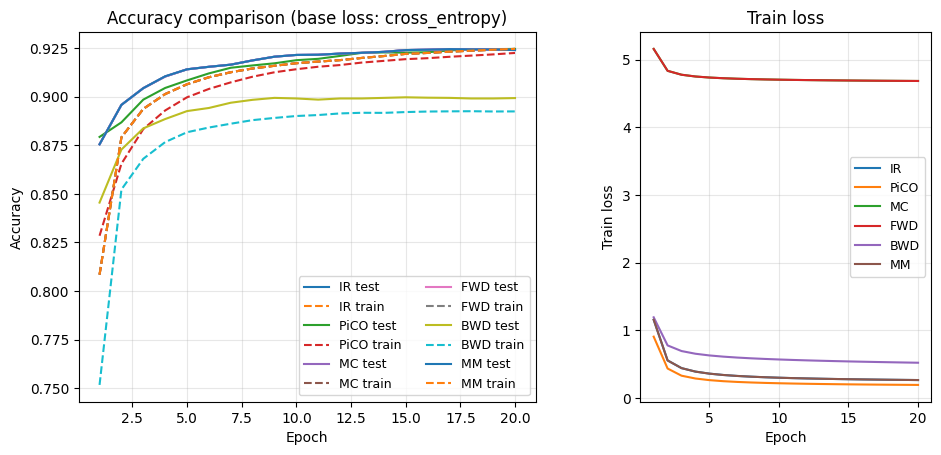


=== Base loss: brier ===
  -> Running method: IR
Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/20: Train Loss: 0.1356, Train Acc: 0.9207, Test Acc: 0.9239, Train Detached Loss: 0.3153, Test Detached Loss: 0.3051, Learning Rate: 0.000001, Epoch Time: 13.46 seconds
Epoch 20/20: Train Loss: 0.1175, Train Acc: 0.9289, Test Acc: 0.9294, Train Detached Loss: 0.2984, Test Detached Loss: 0.2932, Learning Rate: 0.000001, Epoch Time: 13.18 seconds
  -> Running method: PiCO
Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/20: Train Loss: 0.0957, Train Acc: 0.9172, Test Acc: 0.9224, Train Detached Loss: 0.3209, Test Detached Loss: 0.3072, Learning Rate: 0.000001, Epoch Time: 17.28 seconds
Epoch 20/20: Train Loss: 0.0830, Train Acc: 0.9254, Test Acc: 0.9287, Train Detached Loss: 0.3101, Test Detached Loss: 0.3007, Learning Rate: 0.000001, Epoch Time: 17.15 seconds
  -> Running method: MC
Initializing MLP model with 784 inputs, []

/tmp/ipykernel_4013355/4003239821.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved figure: outputs/method_comparison/brier_compare.png


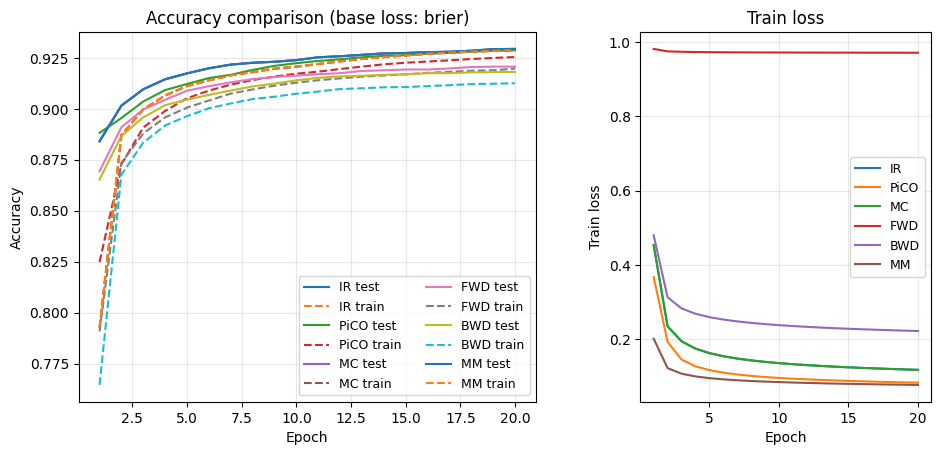


=== Base loss: ps_2 ===
  -> Running method: IR
Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/20: Train Loss: -0.2914, Train Acc: 0.4967, Test Acc: 0.4964, Train Detached Loss: 9.3521, Test Detached Loss: 9.5619, Learning Rate: 0.000001, Epoch Time: 13.99 seconds
Epoch 20/20: Train Loss: -0.2953, Train Acc: 0.4988, Test Acc: 0.4973, Train Detached Loss: 14.0353, Test Detached Loss: 14.3451, Learning Rate: 0.000001, Epoch Time: 13.98 seconds
  -> Running method: PiCO
Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/20: Train Loss: -0.3829, Train Acc: 0.6767, Test Acc: 0.6783, Train Detached Loss: 5.3607, Test Detached Loss: 5.4875, Learning Rate: 0.000001, Epoch Time: 18.36 seconds
Epoch 20/20: Train Loss: -0.3886, Train Acc: 0.6803, Test Acc: 0.6812, Train Detached Loss: 8.0396, Test Detached Loss: 8.2268, Learning Rate: 0.000001, Epoch Time: 19.46 seconds
  -> Running method: MC
Initializing MLP model with 784 input

/tmp/ipykernel_4013355/4003239821.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved figure: outputs/method_comparison/ps_2_compare.png


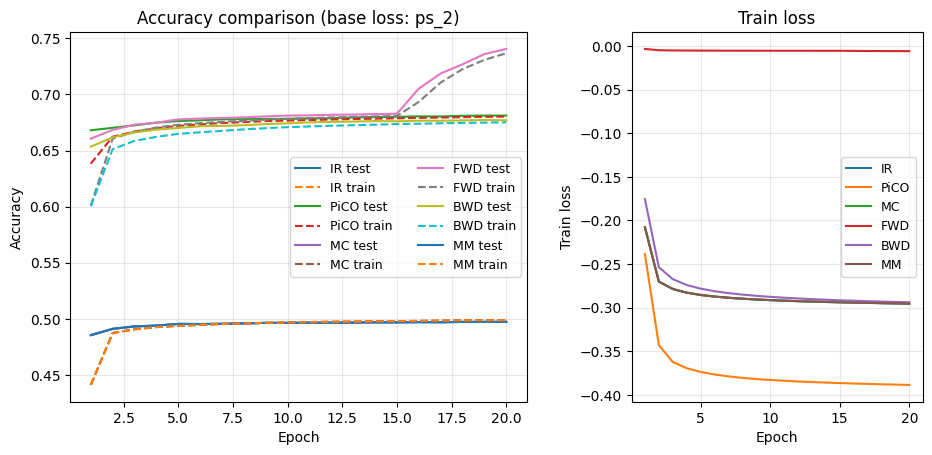


=== Base loss: spherical ===
  -> Running method: IR
Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/20: Train Loss: -0.9128, Train Acc: 0.9237, Test Acc: 0.9270, Train Detached Loss: 0.3309, Test Detached Loss: 0.3203, Learning Rate: 0.000001, Epoch Time: 13.40 seconds
Epoch 20/20: Train Loss: -0.9270, Train Acc: 0.9315, Test Acc: 0.9306, Train Detached Loss: 0.3010, Test Detached Loss: 0.2951, Learning Rate: 0.000001, Epoch Time: 13.19 seconds
  -> Running method: PiCO
Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/20: Train Loss: -0.9455, Train Acc: 0.9189, Test Acc: 0.9235, Train Detached Loss: 0.3241, Test Detached Loss: 0.3107, Learning Rate: 0.000001, Epoch Time: 16.65 seconds
Epoch 20/20: Train Loss: -0.9534, Train Acc: 0.9268, Test Acc: 0.9292, Train Detached Loss: 0.3024, Test Detached Loss: 0.2923, Learning Rate: 0.000001, Epoch Time: 17.65 seconds
  -> Running method: MC
Initializing MLP model with 784 in

ValueError: Unknown loss_code=spherical

In [13]:
#%% All methods comparison (per base loss): save CSV + GridSpec figure
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import numpy as np
import pandas as pd
import random

def set_seed_all(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def sanitize(s: str) -> str:
    return str(s).replace("/", "_").replace(" ", "_").replace(".", "p")

# --------- What to run ---------
base_losses = ["cross_entropy", "brier", "ps_2", "spherical", "tsallis_0.2"]

# Output directory
out_dir = Path("outputs/method_comparison")
out_dir.mkdir(parents=True, exist_ok=True)

# Plot options
show_train_acc = True          # dashed train_acc in the left panel
save_png = True
save_pdf = False

# Training options (use the SAME setting for all methods)
run_seed = 123                 # same init + same RNG for fair comparison
pico_phi = 0.8                 # PiCO hyperparameter
pseudo_label_loc = 3           # must match train_and_evaluate default / dataset.py

# Back up PiCO's mutable pseudo-label tensor (so PiCO won't leak into other runs)
pseudo_backup = None
try:
    pseudo_tensor = train_loader.dataset.tensors[pseudo_label_loc]
    pseudo_backup = pseudo_tensor.detach().clone()
except Exception as e:
    print("Warning: could not back up pseudo labels (PiCO reset may not work):", repr(e))

def restore_pseudo_labels():
    if pseudo_backup is None:
        return
    # in-place restore (important: do not reassign train_loader.dataset.tensors!)
    train_loader.dataset.tensors[pseudo_label_loc].copy_(pseudo_backup)

def make_loss(method: str, loss_code: str):
    """Factory for loss objects, keeping the same style as other notebook cells."""
    if method == "IR":
        return IRLoss(weakener.M, loss_code=loss_code)
    if method == "PiCO":
        return PiCOLoss(loss_code=loss_code)
    if method == "MC":
        return MarginalChainProperLoss(weakener.M, loss_code=loss_code)
    if method == "FWD":
        return ForwardProperLoss(weakener.M, loss_code=loss_code)
    if method == "BWD":
        # Default: use inverse matrix weakener.Y.T (requires compute_Y=True)
        B = weakener.Y.T
        F = np.eye(Data.num_classes)
        return ForwardBackwardProperLoss(B, F, loss_code=loss_code)
    if method == "MM":
        return UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
    raise ValueError(f"Unknown method: {method}")

methods = ["IR", "PiCO", "MC", "FWD", "BWD", "MM"]

for loss_code in base_losses:
    print(f"\n=== Base loss: {loss_code} ===")

    per_method = []

    for method in methods:
        print(f"  -> Running method: {method}")

        # Ensure PiCO doesn't change the dataset for other methods / other losses
        restore_pseudo_labels()

        # Same initialization for fair comparison
        set_seed_all(run_seed)

        # Fresh model + optimizer each run
        model, optimizer = get_model(Data, opt_alg=optimizer_name, lr=lr)

        loss_fn = make_loss(method, loss_code)

        # Train
        model, df = train_and_evaluate(
            model, train_loader, test_loader, optimizer, loss_fn,
            num_epochs=num_epochs,
            pseudolabel_model=method,
            phi=pico_phi,
            seed=run_seed
        )

        df = df.copy()
        df["base_loss"] = loss_code
        per_method.append(df)

    # Restore again at the end of this base loss (clean state)
    restore_pseudo_labels()

    # --------- Save logs ---------
    all_df = pd.concat(per_method, ignore_index=True)
    tag = sanitize(loss_code)

    csv_path = out_dir / f"{tag}_logs.csv"
    all_df.to_csv(csv_path, index=False)
    print(f"Saved logs: {csv_path}")

    # --------- Plot: 2-column (GridSpec), left = accuracy, right = train loss ---------
    fig = plt.figure(figsize=(11, 4.8))
    gs = GridSpec(2, 2, figure=fig, width_ratios=[2.2, 1.4], wspace=0.28, hspace=0.2)

    ax_acc = fig.add_subplot(gs[:, 0])   # left spans two rows
    ax_loss = fig.add_subplot(gs[:, 1])  # right spans two rows

    # Accuracy curves
    for method in methods:
        dfm = all_df[all_df["pseudolabel_model"] == method]
        ax_acc.plot(dfm["epoch"], dfm["test_acc"], label=f"{method} test")
        if show_train_acc and "train_acc" in dfm.columns:
            ax_acc.plot(dfm["epoch"], dfm["train_acc"], linestyle="--", label=f"{method} train")

    ax_acc.set_title(f"Accuracy comparison (base loss: {loss_code})")
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.grid(True, alpha=0.3)
    ax_acc.legend(ncol=2, fontsize=9)

    # Train loss curves
    for method in methods:
        dfm = all_df[all_df["pseudolabel_model"] == method]
        ax_loss.plot(dfm["epoch"], dfm["train_loss"], label=method)

    ax_loss.set_title("Train loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Train loss")
    ax_loss.grid(True, alpha=0.3)
    ax_loss.legend(fontsize=9)

    fig.tight_layout()

    if save_png:
        fig_path = out_dir / f"{tag}_compare.png"
        fig.savefig(fig_path, dpi=200, bbox_inches="tight")
        print(f"Saved figure: {fig_path}")

    if save_pdf:
        fig_path = out_dir / f"{tag}_compare.pdf"
        fig.savefig(fig_path, bbox_inches="tight")
        print(f"Saved figure: {fig_path}")

    plt.show()